In [1]:
from firedrake import *
from pyroteus_adjoint import *
from icepack import compute_surface
from icepack.models import IceStream
from icepack.solvers import FlowSolver
from icepack.constants import (
    ice_density as rho_I,
    water_density as rho_W,
    gravity as g,
    weertman_sliding_law as m,
)
from glac_adapt.adapt import mismip_bed_topography, friction_law
from glac_adapt.meshadapt import adapt
from glac_adapt.options import Options
from tqdm import trange
import argparse
from math import ceil
import os
# from pyroteus.options import GoalOrientedParameters

# rank = COMM_WORLD.rank
# print(rank)

# parser = argparse.ArgumentParser()
# parser.add_argument('--chk-idx', type=int, default=0)
# parser.add_argument('--input', type=str)
# parser.add_argument('--output', type=str)

# args = parser.parse_args()


def get_function_spaces(mesh):
    """
    Get the finite element space for a given mesh.
    """
    return {"u": VectorFunctionSpace(mesh, "CG", 2)}


def get_solver(mesh_seq):
    options = mesh_seq.options

    def solver(index, ic):
        """
        Solve forward over time window (`t_start`, `t_end`).
        """
        t_start, t_end = mesh_seq.time_partition.subintervals[index]
        msh = ic.u.function_space().mesh()
        fspace = ic.u.function_space()

        options.simulation_end_time = t_end

        u_ = Function(fspace, name="u_old")
        u_.assign(ic["u"])
        u = Function(fspace, name="u")
        u.assign(u_)

        Q = FunctionSpace(msh, "CG", fspace._ufl_element.degree())

        mesh_seq.icepack_model = IceStream(friction=friction_law)
        mesh_seq.icepack_solver = FlowSolver(
            mesh_seq.icepack_model, **options.domain, **options.solvers)

        mesh_seq.z_b = interpolate(mismip_bed_topography(msh, options.domain.Ly), Q)
        mesh_seq.h = interpolate(Constant(100), Q)
        mesh_seq.s = compute_surface(thickness=mesh_seq.h, bed=mesh_seq.z_b)

        h_0 = mesh_seq.h.copy(deepcopy=True)
        num_steps = int((t_end - t_start) / mesh_seq.options.simulation.timestep)
        progress_bar = trange(num_steps)

        for _ in progress_bar:
            mesh_seq.h = mesh_seq.icepack_solver.prognostic_solve(
                        options.timestep,
                        thickness=mesh_seq.h,
                        velocity=u,
                        accumulation=options.constants.acc_rate,
                        thickness_inflow=h_0
            )
            mesh_seq.h.interpolate(max_value(mesh_seq.h, 1.0))
            mesh_seq.s = compute_surface(thickness=mesh_seq.h, bed=mesh_seq.z_b)

            u = mesh_seq.icepack_solver.diagnostic_solve(
                velocity=u,
                thickness=mesh_seq.h,
                surface=mesh_seq.s,
                fluidity=options.constants.viscosity,
                friction=options.constants.friction
            )

            min_h = mesh_seq.h.dat.data_ro.min()
            max_h = mesh_seq.h.dat.data_ro.max()
            # avg_h = assemble(mesh_seq.h * dx) / (options.domain.Lx * options.domain.Ly)
            progress_bar.set_description(f"avg, min h: {min_h:4.2f}, {max_h:4.2f}")

            # qoi = mesh_seq.get_qoi(i)

        return {"u": u}
    return solver

def get_initial_condition(mesh_seq):
    V = mesh_seq.function_spaces["u"][0]
    x = SpatialCoordinate(mesh_seq[0])[0]
    u = interpolate(as_vector((90 * x / mesh_seq.options.domain.Lx, 0)), V)

    return {'u': u}
    
def get_form(mesh_seq):
    def form(index, sols):
        u, u_ = sols["u"]

        action = mesh_seq.icepack_solver._diagnostic_solver._model.action(
            velocity=u,
            thickness=mesh_seq.h,
            surface=mesh_seq.s,
            fluidity=mesh_seq.options.constants.viscosity,
            friction=mesh_seq.options.constants.friction,
            **mesh_seq.options.domain
        )

        F = derivative(action, u)

        return F
    return form


def get_qoi(mesh_seq, sol, index):
    def qoi():
        u = sol["u"]
        msh = mesh_seq[index]

        # metadata = {
        #     "quadrature_degree": mesh_seq.icepack_solver._diagnostic_solver._model.quadrature_degree(velocity=u, thickness=mesh_seq.h),
        # }
        # _ds = ds(domain=msh, metadata=metadata)

        v = FacetNormal(msh)
        j = mesh_seq.h * inner(u, v) * ds(mesh_seq.options.domain.ice_front_ids)

        return j
    return qoi


def get_bcs(mesh_seq):
    def bcs(index):
        V = mesh_seq.function_spaces["u"][index]

        if hasattr(V._ufl_element, "_sub_element"):
            bc = DirichletBC(V, Constant((0, 0)), mesh_seq.options.domain.dirichlet_ids)
        else:
            bc = DirichletBC(V, Constant(0), mesh_seq.options.domain.dirichlet_ids)
        if not mesh_seq.options.domain.dirichlet_ids:
            bc = None

        return bc
    return bcs


# def adaptor(mesh_seq, sols, inds):
#     mesh_seq.options.simulation.chk_idx += 1
#     chk_idx = mesh_seq.options.simulation.chk_idx
#     sol_u = sols['u']['forward'][0][-1]
#     err_ind = inds[-1][-1]

#     # Q = FunctionSpace(mesh_seq[0], family='CG', degree=1)
#     # ux = Function(Q)
#     # ux.interpolate(sol_u[0])
#     # uy = Function(Q)
#     # uy.interpolate(sol_u[1])
#     # hessianx = recover_hessian(ux)
#     # hessiany = recover_hessian(uy)
#     # hmetricx = hessian_metric(hessianx)
#     # hmetricy = hessian_metric(hessiany)

#     # int_metric = metric_intersection(hmetricx, hmetricy)
#     final_metric = isotropic_metric(err_ind)

#     metcom = metric_complexity(final_metric)#hmetricx)
#     Nvert = 3000
#     d = 2
#     alpha = (Nvert / metcom) ** (2/d)

#     # hmetricx.assign(alpha*hmetricx)
#     final_metric.assign(alpha*final_metric)

#     print(mesh_seq[0].name)
#     print('chk chk idx', chk_idx)

#     with CheckpointFile(f'{options.simulation.output}/adapted_{chk_idx}.h5', 'w') as afile:
#         afile.save_mesh(mesh_seq[0])
#         # afile.save_function(hmetricx, name="metric")
#         afile.save_function(final_metric, name='metric')
#         afile.save_function(sol_u, name="u_forward")
#         afile.save_function(sols["u"]["adjoint"][-1][-1], name="u_adjoint")
#         afile.save_function(err_ind, name="error_indicator")

#     if rank == 0:
#         with CheckpointFile(f'{options.simulation.output}/adapted_{chk_idx}.h5', 'r', comm=COMM_SELF) as afile:
#             old_mesh = afile.load_mesh(f"mesh_{chk_idx-1}")
#             load_metric = afile.load_function(old_mesh, "metric")

#         adapted_mesh = adapt(old_mesh, load_metric, name=f"mesh_{chk_idx}")

    #     print('old, new num_cells: ', old_mesh.num_cells(), adapted_mesh.num_cells())

    #     with CheckpointFile(f'{options.simulation.output}/adapted_{chk_idx}.h5', 'a', comm=COMM_SELF) as afile:
    #         afile.save_mesh(adapted_mesh)

    # COMM_WORLD.barrier()

    # with CheckpointFile(f'{options.simulation.output}/adapted_{chk_idx}.h5', 'r') as afile:
    #     adapted_mesh = afile.load_mesh(f"mesh_{chk_idx}")
        
    # mesh_seq.meshes = [adapted_mesh]

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
import numpy as np
from numpy.linalg import eigh

def metric_from_hessian(hessian, tol):  # B is the 2d hessian matrix 2x2
    l_min = 1.
    l_max = 50e3

    B = np.array(hessian)

    # Compute mean diagonal and set values appropriately
    B[0, 1] = 0.5 * (B[0, 1] + B[1, 0])
    B[1, 0] = B[0, 1]

    # Solve eigenvalue problem
    eigen_values, eigen_vectors = eigh(B)

    # Take modulus of eigenvalues
    # eigen_values = np.clip(np.abs(eigen_values), l_min, l_max)
    mod_eigen_values = np.minimum(np.maximum(2/9 / tol * np.abs(eigen_values), 1/l_max**2), 1/l_min**2)

    # Build metric from eigendecomposition
    Q = eigen_vectors
    D = np.diag(mod_eigen_values)
    # A += Q @ D @ Q.T

    M = Q @ D @ Q.T
    return M

def adaptor_new(mesh_seq, sols):
    sol_u = sols.u.forward[-1][-1]
    old_mesh = mesh_seq[0]

    Q = FunctionSpace(old_mesh, family='CG', degree=1)
    ux = Function(Q)
    ux.interpolate(sol_u[0])
    ux_hess = recover_hessian(ux)

    ux_hess_data = ux_hess.dat.data
    ux_hess_met_fnA = hessian_metric(ux_hess)
    ux_hess_met_fnA_temp = np.zeros(ux_hess_data.shape)

    for i in range(ux_hess_met_fnA_temp.shape[0]):
        ux_hess_met_fnA_temp[i] = metric_from_hessian(ux_hess_data[i], 0.1)
        # print(hess_data[i])
        # print(hess_met[i])
    ux_hess_met_fnA.dat.data[:] = ux_hess_met_fnA_temp

    metcom = metric_complexity(ux_hess_met_fnA)
    Nvert = 2000
    d = 2
    alpha = (Nvert / metcom) ** (2/d)

    # hmetricx.assign(alpha*hmetricx)
    ux_hess_met_fnA.assign(alpha*ux_hess_met_fnA)

    adapted_mesh_ux_FnA = adapt(old_mesh, ux_hess_met_fnA)
    print(adapted_mesh_ux_FnA.num_vertices())
    meshes.append(adapted_mesh_ux_FnA)

    mesh_seq.meshes = [adapted_mesh_ux_FnA]

In [3]:
chk_idx = 0  #args.chk_idx
opts = {
    "timestep": 10.0, 
    "end_time": 3000.0, 
    "chk_idx": chk_idx, 
# "output": args.output, "input": args.input,
# 'ditichlet_ids': tuple([4]), 'side_wall_ids': tuple([1,3]),
}
options = Options(**opts)

output_dir = f"{os.getcwd()}/{options.simulation.output}"
if not os.path.isdir(output_dir):
    os.makedirs(output_dir)

# if chk_idx == 0:
#     # with CheckpointFile("initial_mesh.h5", 'r') as afile:
#         # initial_mesh = afile.load_mesh("firedrake_default")
#     initial_mesh = RectangleMesh(100, 16, options.domain.Lx, options.domain.Ly, name="mesh_0")
# else:
#     with CheckpointFile(f"{options.simulation.input}/adapted_{chk_idx}.h5", 'r') as afile:
#         initial_mesh = afile.load_mesh(f"mesh_{chk_idx}")

initial_mesh = RectangleMesh(128, 16, options.domain.Lx, options.domain.Ly)
options.initial_mesh = initial_mesh

fields = ["u"]
num_subintervals=1
meshes = [options.initial_mesh]
time_partition = TimePartition(
    options.simulation.end_time,
    num_subintervals,
    options.simulation.timestep,
    fields,
    timesteps_per_export=ceil(options.simulation.end_time/(options.simulation.timestep*10)),
)


# msq = GoalOrientedMeshSeq(
msq = MeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_bcs=get_bcs,
    get_solver=get_solver,
    get_qoi=get_qoi,
    qoi_type="steady",
    # **params,
)
msq.options = options
# msq.fixed_point_iteration(adaptor)

In [ ]:
meshes = []
# solutions = msq.solve_forward()
msq.fixed_point_iteration(adaptor_new)

avg, min h: 40.72, 1195.33: 100%|██████████| 300/300 [08:45<00:00,  1.75s/it]
WARNING MeshSeq: Solve block for field 'u' on subinterval 0 has no dependencies


2260


avg, min h: 31.55, 1210.98: 100%|██████████| 300/300 [27:52<00:00,  5.57s/it]


2539


avg, min h: 37.39, 1193.83: 100%|██████████| 300/300 [41:40<00:00,  8.33s/it]


2684


avg, min h: 43.64, 1195.09: 100%|██████████| 300/300 [41:20<00:00,  8.27s/it]


2774


avg, min h: 59.96, 295.20:   7%|▋         | 22/300 [07:55<1:31:00, 19.64s/it]

: 

: 

In [19]:
sol_u = solutions.u.forward[-1][-1]
sol_h = msq.h
sol_s = msq.s

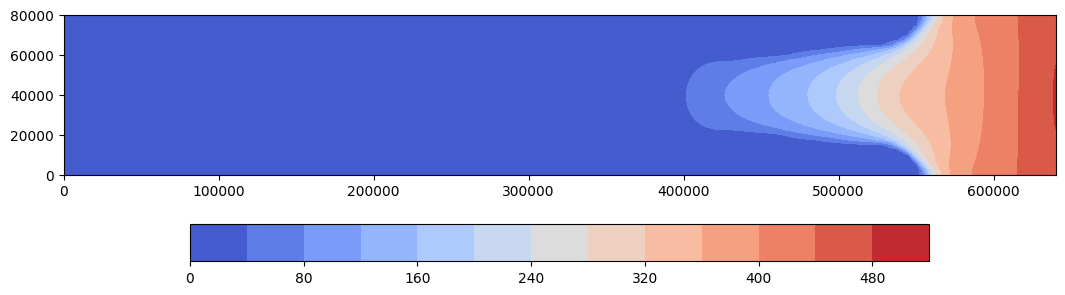

In [20]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(12.8, 3.2))
im = tricontourf(sol_u, axes=axes, **{"cmap": "coolwarm", "levels": 15,})
fig.colorbar(im, orientation="horizontal", pad=0.2)

In [21]:
from glac_adapt.meshadapt import adapt

Q = FunctionSpace(initial_mesh, family='CG', degree=1)
ux = Function(Q)
ux.interpolate(sol_u[0])
uy = Function(Q)
uy.interpolate(sol_u[1])
ux_hess = recover_hessian(ux)
uy_hess = recover_hessian(uy)
ux_hess_met = hessian_metric(ux_hess)
uy_hess_met = hessian_metric(uy_hess)

h_hess = recover_hessian(sol_h)
h_hess_met = hessian_metric(h_hess)

s_hess = recover_hessian(sol_s)
s_hess_met = hessian_metric(s_hess)

In [22]:
adapted_mesh_ux = adapt(initial_mesh, ux_hess_met)
print(adapted_mesh_ux.num_vertices())

adapted_mesh_h = adapt(initial_mesh, h_hess_met)
print(adapted_mesh_h.num_vertices())

adapted_mesh_s = adapt(initial_mesh, s_hess_met)
print(adapted_mesh_s.num_vertices())

4132
14088
4209


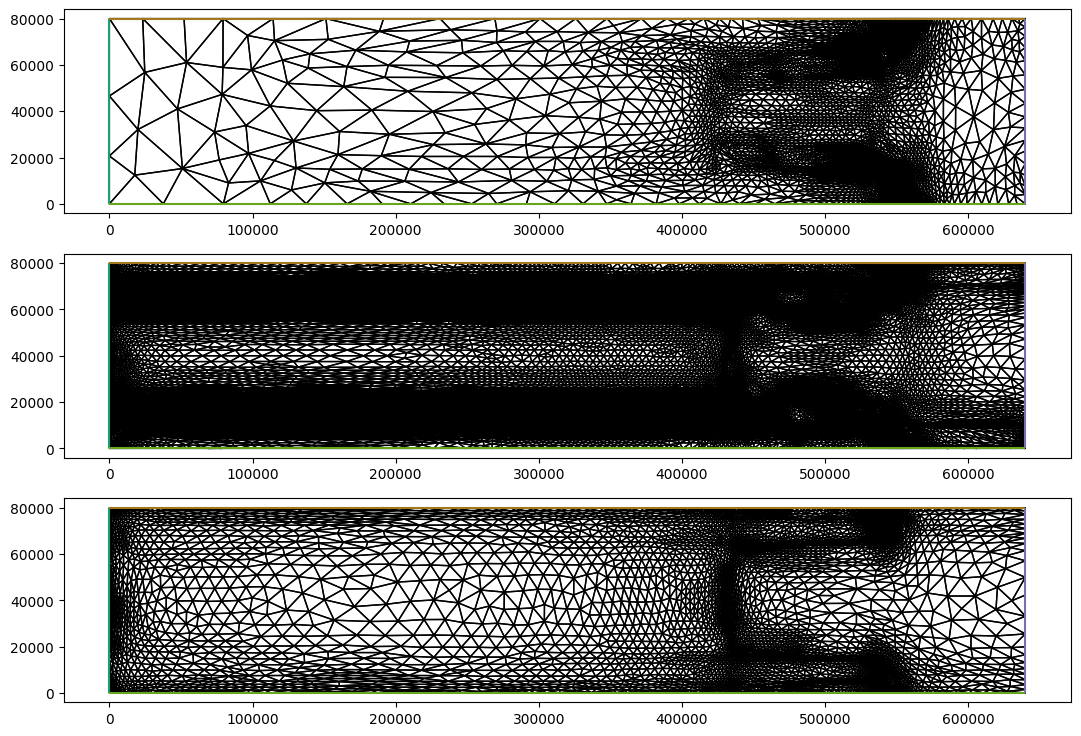

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(13, 9))
triplot(adapted_mesh_ux, axes=axes[0])
triplot(adapted_mesh_h, axes=axes[1])
triplot(adapted_mesh_s, axes=axes[2])


In [26]:
import numpy as np
from numpy.linalg import eigh

def metric_from_hessian(hessian, tol):  # B is the 2d hessian matrix 2x2
    l_min = 1.
    l_max = 50e3

    B = np.array(hessian)

    # Compute mean diagonal and set values appropriately
    B[0, 1] = 0.5 * (B[0, 1] + B[1, 0])
    B[1, 0] = B[0, 1]

    # Solve eigenvalue problem
    eigen_values, eigen_vectors = eigh(B)

    # Take modulus of eigenvalues
    # eigen_values = np.clip(np.abs(eigen_values), l_min, l_max)
    mod_eigen_values = np.minimum(np.maximum(2/9 / tol * np.abs(eigen_values), 1/l_max**2), 1/l_min**2)

    # Build metric from eigendecomposition
    Q = eigen_vectors
    D = np.diag(mod_eigen_values)
    # A += Q @ D @ Q.T

    M = Q @ D @ Q.T
    return M

In [30]:
ux_hess_data = ux_hess.dat.data
ux_hess_met_fnA = hessian_metric(ux_hess)
ux_hess_met_fnA_temp = np.zeros(ux_hess_data.shape)
# hess_data.shape

for i in range(ux_hess_met_fnA_temp.shape[0]):
    ux_hess_met_fnA_temp[i] = metric_from_hessian(ux_hess_data[i], 0.1)
    # print(hess_data[i])
    # print(hess_met[i])

ux_hess_met_fnA.dat.data[:] = ux_hess_met_fnA_temp * 0.1

In [31]:
adapted_mesh_ux_FnA = adapt(initial_mesh, ux_hess_met_fnA)
print(adapted_mesh_ux_FnA.num_vertices())

1244


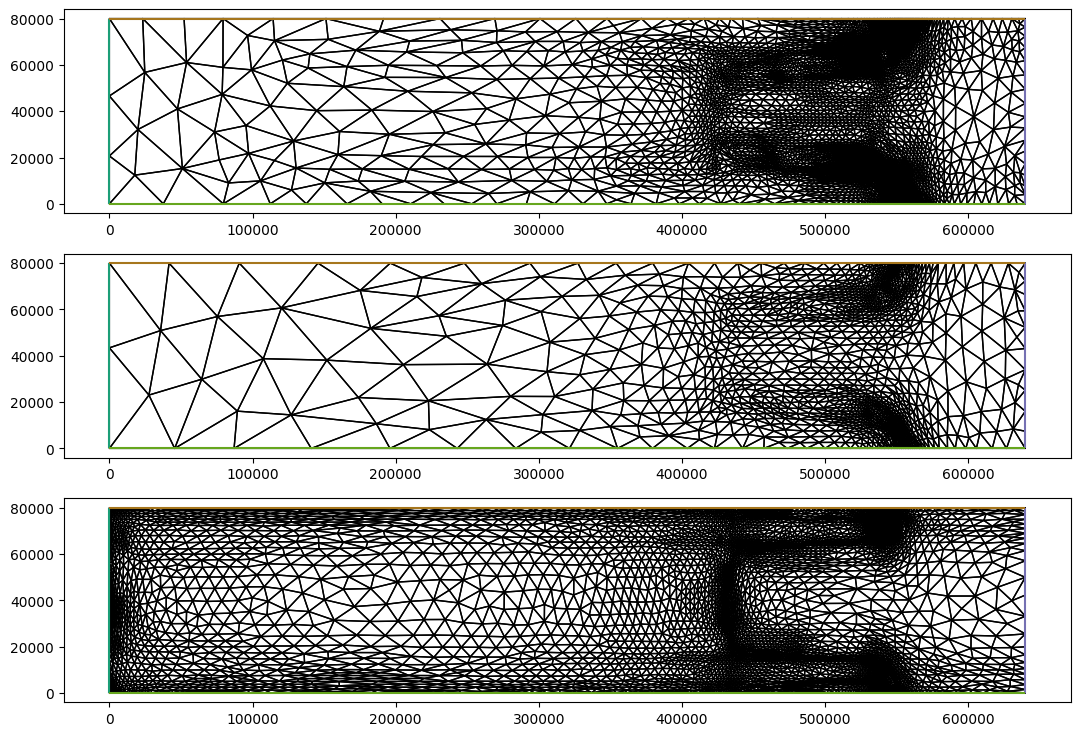

In [32]:
fig, axes = plt.subplots(3, 1, figsize=(13, 9))
triplot(adapted_mesh_ux, axes=axes[0])
triplot(adapted_mesh_ux_FnA, axes=axes[1])
triplot(adapted_mesh_s, axes=axes[2])
